In [1]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, make_scorer, precision_score
from sklearn import metrics
import os
import json
from werkzeug.utils import secure_filename
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

from app import calcular_caract, file_to_binary, leer_img

### 1. Definir función de características:

In [ ]:
# AÑADIR FUNCIÓN:
def caract(filename) -> np.array:
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    pass

In [2]:
def histograma_lab(filename, bins, mask=None):
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # Convierte la imagen a espacio L*a*b*.
    histogram = cv2.calcHist([img], [0, 1, 2], mask, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    histogram = cv2.normalize(histogram, histogram).flatten()
    return histogram

In [4]:
def histograma_rgb(filename, bins, mask=None):
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convierte la imagen a espacio L*a*b*.
    histogram = cv2.calcHist([img], [0, 1, 2], mask, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    histogram = cv2.normalize(histogram, histogram).flatten()
    return histogram

### 2. Calcular característica para todo dataset:

In [3]:
d = []

for i in range(0, 1000):
    if os.path.isfile(os.path.join('static', str(i) + '.jpg')):
        path = os.path.join('static', str(i) + '.jpg')
        hist = histograma_lab(path, 8) ## CAMBIAR FUNCIÓN CARACTERÍSTICAS
        d.append(hist)

In [4]:
# comprobar que sale 1000

len(d)

1000

### 3. Generar df: 

INFO: hay 10 clases (las del vector 'clases'). las 100 primeras imags (0.jpg - 99.jpg) corresponden a la clase 'indigena', las 100 siguientes (100.jpg - 199.jpg) a la clase playa, ... y así.

In [5]:
df = pd.DataFrame(d)

clases = ['indigena', 'playa', 'monumento', 'autobus', 'dinosaurio', 'elefante', 'rosa', 'caballo', 'montaña', 'comida']
labels = []

for c in clases: 
    labels += [c]*100

df['class'] = labels

In [26]:
# comprobar que se ha añadido columna class:

df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,indigena
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,indigena
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,indigena
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,indigena
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,indigena


### 4. Entrenar y evaluar modelo KNN:

In [6]:
X_test = df.iloc[::10,0:512] # 0.jpg, 10.jpg, 20.jpg, ...
y_test = df['class'][::10]

In [14]:
X_test.shape

(100, 512)

In [29]:
X_train = df.iloc[:,0:512].drop(X_test.index)
y_train = df['class'].drop(X_test.index)

In [23]:
X_train.shape

(900, 513)

In [30]:
knn = neighbors.KNeighborsClassifier(n_neighbors=2, metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=2)

In [33]:
yhatTest = knn.predict(X_test)

print(confusion_matrix(y_test,yhatTest))
print(classification_report(y_test,yhatTest))
print("Test accuracy",metrics.accuracy_score(y_test, yhatTest))
print("Test Precision",metrics.precision_score(y_test, yhatTest, average='macro'))
print("Test Recall",metrics.recall_score(y_test, yhatTest, average='macro'))

[[ 7  1  0  0  0  1  0  0  1  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  2  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  1  0  8  0  1  0  0  0]
 [ 0  1  1  0  0  7  0  0  1  0]
 [ 2  0  0  0  0  0  6  1  0  1]
 [ 1  1  0  0  0  3  1  4  0  0]
 [ 2  0  0  0  1  3  2  2  0  0]
 [ 0  1  1  0  0  0  0  0  0  8]]
              precision    recall  f1-score   support

     autobus       0.58      0.70      0.64        10
     caballo       0.71      1.00      0.83        10
      comida       0.73      0.80      0.76        10
  dinosaurio       1.00      1.00      1.00        10
    elefante       0.73      0.80      0.76        10
    indigena       0.50      0.70      0.58        10
     montaña       0.60      0.60      0.60        10
   monumento       0.57      0.40      0.47        10
       playa       0.00      0.00      0.00        10
        rosa       0.89      0.80      0.84        10

    accuracy                           0.68       100
   macro avg       

### 5. Visualizar resultados para una imagen de entrada

In [37]:
def plot_c(filename):
    h = histograma_lab(filename, 8) ## CAMBIAR FUNCIÓN CARACTERÍSTICAS
    vs = knn.kneighbors(h.reshape(1, -1), 10)[1].tolist()[0]

    plt.figure(figsize=(20, 10))
    i = 1
    for v in vs: 
        path = os.path.join('static', str(v) + '.jpg')
        img = leer_img(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1,10,i)
        plt.imshow(img)
        i += 1

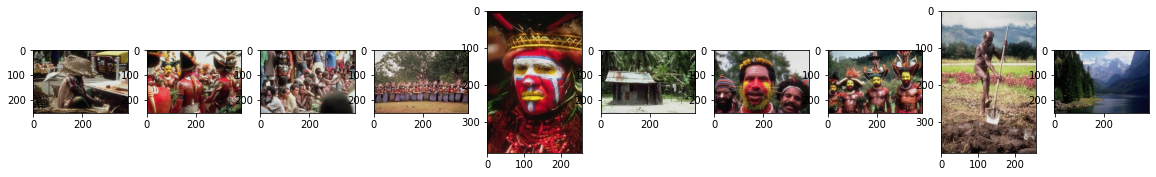

In [38]:
filename = 'static/0.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)


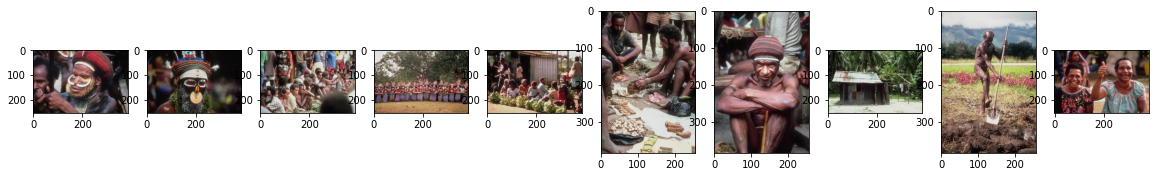

In [41]:
filename = 'static/10.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)

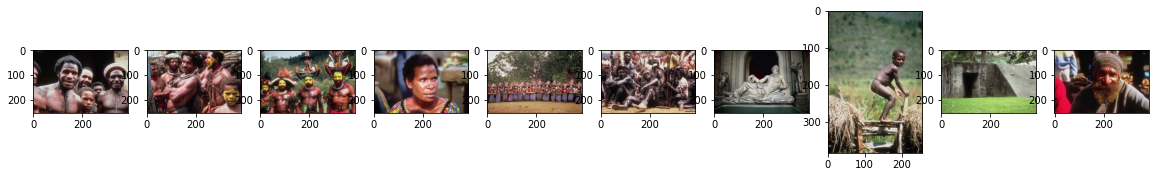

In [42]:
filename = 'static/20.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)